In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pydotplus
!pip install graphviz

In [3]:
from __future__ import division, print_function
import gensim
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
import wordcloud
import numpy as np
import pandas as pd
import os
import collections
import re
import string
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [4]:
df = pd.read_excel('/content/drive/MyDrive/Datasets/Code Mixed Hindi-English tweets.xlsx')
df.drop(['id'], axis=1, inplace=True)
df.tail()

,tweets,labels
9160,gujarati fraud kyu hotey hai? pnbscam,3
9161,saala idhar 7 lakh k car loan k liye bank choo...,3
9162,mitron nirav modi ji ka relation india k kaun ...,3
9163,or yahn ek month k education loan ki emi pay n...,2
9164,jis bank me 500 rupye niklwane k liye ghnto kh...,3


## Labels are as follows:
0 - No emotions,
1 - Happy,
2 - Sad,
3 - Angry,
4 - Fear,
5 - Disgust,
6 - Surprise

In [5]:
print("Dataset shape: ", df.shape)
df['labels'].value_counts()

Dataset shape:  (9165, 2)


0    1892
3    1763
2    1529
1    1226
5    1147
6    1049
4     559
Name: labels, dtype: int64

# Cleaning data:

In [6]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [7]:
punctuations_list = string.punctuation
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

df['tweets'] = df['tweets'].apply(lambda x: cleaning_punctuations(x))

In [8]:
# Using Hinglish stopwords which contains 1036 words from both English and Hindi languages
# Source: https://github.com/TrigonaMinima/HinglishNLP/blob/master/data/assets/stop_hinglish

stopwordlist = ['a', 'aadi', 'aaj', 'aap', 'aapne', 'aata', 'aati', 'aaya', 'aaye', 'ab', 'abbe', 'abbey', 'abe', 'abhi', 'able', 'about', 'above', 'accha', 'according', 'accordingly', 'acha', 'achcha', 'across', 'actually', 'after', 'afterwards', 'again', 'against', 'agar', 'ain', 'aint', "ain't", 'aisa', 'aise', 'aisi', 'alag', 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'andar', 'another', 'any', 'anybody', 'anyhow', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'ap', 'apan', 'apart', 'apna', 'apnaa', 'apne', 'apni', 'appear', 'are', 'aren', 'arent', "aren't", 'around', 'arre', 'as', 'aside', 'ask', 'asking', 'at', 'aur', 'avum', 'aya', 'aye', 'baad', 'baar', 'bad', 'bahut', 'bana', 'banae', 'banai', 'banao', 'banaya', 'banaye', 'banayi', 'banda', 'bande', 'bandi', 'bane', 'bani', 'bas', 'bata', 'batao', 'bc', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'best', 'better', 'between', 'beyond', 'bhai', 'bheetar', 'bhi', 'bhitar', 'bht', 'bilkul', 'bohot', 'bol', 'bola', 'bole', 'boli', 'bolo', 'bolta', 'bolte', 'bolti', 'both', 'brief', 'bro', 'btw', 'but', 'by', 'came', 'can', 'cannot', 'cant', "can't", 'cause', 'causes', 'certain', 'certainly', 'chahiye', 'chaiye', 'chal', 'chalega', 'chhaiye', 'clearly', "c'mon", 'com', 'come', 'comes', 'could', 'couldn', 'couldnt', "couldn't", 'd', 'de', 'dede', 'dega', 'degi', 'dekh', 'dekha', 'dekhe', 'dekhi', 'dekho', 'denge', 'dhang', 'di', 'did', 'didn', 'didnt', "didn't", 'dijiye', 'diya', 'diyaa', 'diye', 'diyo', 'do', 'does', 'doesn', 'doesnt', "doesn't", 'doing', 'done', 'dono', 'dont', "don't", 'doosra', 'doosre', 'down', 'downwards', 'dude', 'dunga', 'dungi', 'during', 'dusra', 'dusre', 'dusri', 'dvaara', 'dvara', 'dwaara', 'dwara', 'each', 'edu', 'eg', 'eight', 'either', 'ek', 'else', 'elsewhere', 'enough', 'etc', 'even', 'ever', 'every', 'everybody', 'everyone', 'everything', 'everywhere', 'ex', 'exactly', 'example', 'except', 'far', 'few', 'fifth', 'fir', 'first', 'five', 'followed', 'following', 'follows', 'for', 'forth', 'four', 'from', 'further', 'furthermore', 'gaya', 'gaye', 'gayi', 'get', 'gets', 'getting', 'ghar', 'given', 'gives', 'go', 'goes', 'going', 'gone', 'good', 'got', 'gotten', 'greetings', 'haan', 'had', 'hadd', 'hadn', 'hadnt', "hadn't", 'hai', 'hain', 'hamara', 'hamare', 'hamari', 'hamne', 'han', 'happens', 'har', 'hardly', 'has', 'hasn', 'hasnt', "hasn't", 'have', 'haven', 'havent', "haven't", 'having', 'he', 'hello', 'help', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', "here's", 'hereupon', 'hers', 'herself', "he's", 'hi', 'him', 'himself', 'his', 'hither', 'hm', 'hmm', 'ho', 'hoga', 'hoge', 'hogi', 'hona', 'honaa', 'hone', 'honge', 'hongi', 'honi', 'hopefully', 'hota', 'hotaa', 'hote', 'hoti', 'how', 'howbeit', 'however', 'hoyenge', 'hoyengi', 'hu', 'hua', 'hue', 'huh', 'hui', 'hum', 'humein', 'humne', 'hun', 'huye', 'huyi', 'i', "i'd", 'idk', 'ie', 'if', "i'll", "i'm", 'imo', 'in', 'inasmuch', 'inc', 'inhe', 'inhi', 'inho', 'inka', 'inkaa', 'inke', 'inki', 'inn', 'inner', 'inse', 'insofar', 'into', 'inward', 'is', 'ise', 'isi', 'iska', 'iskaa', 'iske', 'iski', 'isme', 'isn', 'isne', 'isnt', "isn't", 'iss', 'isse', 'issi', 'isski', 'it', "it'd", "it'll", 'itna', 'itne', 'itni', 'itno', 'its', "it's", 'itself', 'ityaadi', 'ityadi', "i've", 'ja', 'jaa', 'jab', 'jabh', 'jaha', 'jahaan', 'jahan', 'jaisa', 'jaise', 'jaisi', 'jata', 'jayega', 'jidhar', 'jin', 'jinhe', 'jinhi', 'jinho', 'jinhone', 'jinka', 'jinke', 'jinki', 'jinn', 'jis', 'jise', 'jiska', 'jiske', 'jiski', 'jisme', 'jiss', 'jisse', 'jitna', 'jitne', 'jitni', 'jo', 'just', 'jyaada', 'jyada', 'k', 'ka', 'kaafi', 'kab', 'kabhi', 'kafi', 'kaha', 'kahaa', 'kahaan', 'kahan', 'kahi', 'kahin', 'kahte', 'kaisa', 'kaise', 'kaisi', 'kal', 'kam', 'kar', 'kara', 'kare', 'karega', 'karegi', 'karen', 'karenge', 'kari', 'karke', 'karna', 'karne', 'karni', 'karo', 'karta', 'karte', 'karti', 'karu', 'karun', 'karunga', 'karungi', 'kaun', 'kaunsa', 'kayi', 'kch', 'ke', 'keep', 'keeps', 'keh', 'kehte', 'kept', 'khud', 'ki', 'kin', 'kine', 'kinhe', 'kinho', 'kinka', 'kinke', 'kinki', 'kinko', 'kinn', 'kino', 'kis', 'kise', 'kisi', 'kiska', 'kiske', 'kiski', 'kisko', 'kisliye', 'kisne', 'kitna', 'kitne', 'kitni', 'kitno', 'kiya', 'kiye', 'know', 'known', 'knows', 'ko', 'koi', 'kon', 'konsa', 'koyi', 'krna', 'krne', 'kuch', 'kuchch', 'kuchh', 'kul', 'kull', 'kya', 'kyaa', 'kyu', 'kyuki', 'kyun', 'kyunki', 'lagta', 'lagte', 'lagti', 'last', 'lately', 'later', 'le', 'least', 'lekar', 'lekin', 'less', 'lest', 'let', "let's", 'li', 'like', 'liked', 'likely', 'little', 'liya', 'liye', 'll', 'lo', 'log', 'logon', 'lol', 'look', 'looking', 'looks', 'ltd', 'lunga', 'm', 'maan', 'maana', 'maane', 'maani', 'maano', 'magar', 'mai', 'main', 'maine', 'mainly', 'mana', 'mane', 'mani', 'mano', 'many', 'mat', 'may', 'maybe', 'me', 'mean', 'meanwhile', 'mein', 'mera', 'mere', 'merely', 'meri', 'might', 'mightn', 'mightnt', "mightn't", 'mil', 'mjhe', 'more', 'moreover', 'most', 'mostly', 'much', 'mujhe', 'must', 'mustn', 'mustnt', "mustn't", 'my', 'myself', 'na', 'naa', 'naah', 'nahi', 'nahin', 'nai', 'name', 'namely', 'nd', 'ne', 'near', 'nearly', 'necessary', 'neeche', 'need', 'needn', 'neednt', "needn't", 'needs', 'neither', 'never', 'nevertheless', 'new', 'next', 'nhi', 'nine', 'no', 'nobody', 'non', 'none', 'noone', 'nope', 'nor', 'normally', 'not', 'nothing', 'novel', 'now', 'nowhere', 'o', 'obviously', 'of', 'off', 'often', 'oh', 'ok', 'okay', 'old', 'on', 'once', 'one', 'ones', 'only', 'onto', 'or', 'other', 'others', 'otherwise', 'ought', 'our', 'ours', 'ourselves', 'out', 'outside', 'over', 'overall', 'own', 'par', 'pata', 'pe', 'pehla', 'pehle', 'pehli', 'people', 'per', 'perhaps', 'phla', 'phle', 'phli', 'placed', 'please', 'plus', 'poora', 'poori', 'provides', 'pura', 'puri', 'q', 'que', 'quite', 'raha', 'rahaa', 'rahe', 'rahi', 'rakh', 'rakha', 'rakhe', 'rakhen', 'rakhi', 'rakho', 'rather', 're', 'really', 'reasonably', 'regarding', 'regardless', 'regards', 'rehte', 'rha', 'rhaa', 'rhe', 'rhi', 'ri', 'right', 's', 'sa', 'saara', 'saare', 'saath', 'sab', 'sabhi', 'sabse', 'sahi', 'said', 'sakta', 'saktaa', 'sakte', 'sakti', 'same', 'sang', 'sara', 'sath', 'saw', 'say', 'saying', 'says', 'se', 'second', 'secondly', 'see', 'seeing', 'seem', 'seemed', 'seeming', 'seems', 'seen', 'self', 'selves', 'sensible', 'sent', 'serious', 'seriously', 'seven', 'several', 'shall', 'shan', 'shant', "shan't", 'she', "she's", 'should', 'shouldn', 'shouldnt', "shouldn't", "should've", 'si', 'since', 'six', 'so', 'soch', 'some', 'somebody', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhat', 'somewhere', 'soon', 'still', 'sub', 'such', 'sup', 'sure', 't', 'tab', 'tabh', 'tak', 'take', 'taken', 'tarah', 'teen', 'teeno', 'teesra', 'teesre', 'teesri', 'tell', 'tends', 'tera', 'tere', 'teri', 'th', 'tha', 'than', 'thank', 'thanks', 'thanx', 'that', "that'll", 'thats', "that's", 'the', 'theek', 'their', 'theirs', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein', 'theres', "there's", 'thereupon', 'these', 'they', "they'd", "they'll", "they're", "they've", 'thi', 'thik', 'thing', 'think', 'thinking', 'third', 'this', 'tho', 'thoda', 'thodi', 'thorough', 'thoroughly', 'those', 'though', 'thought', 'three', 'through', 'throughout', 'thru', 'thus', 'tjhe', 'to', 'together', 'toh', 'too', 'took', 'toward', 'towards', 'tried', 'tries', 'true', 'truly', 'try', 'trying', 'tu', 'tujhe', 'tum', 'tumhara', 'tumhare', 'tumhari', 'tune', 'twice', 'two', 'um', 'umm', 'un', 'under', 'unhe', 'unhi', 'unho', 'unhone', 'unka', 'unkaa', 'unke', 'unki', 'unko', 'unless', 'unlikely', 'unn', 'unse', 'until', 'unto', 'up', 'upar', 'upon', 'us', 'use', 'used', 'useful', 'uses', 'usi', 'using', 'uska', 'uske', 'usne', 'uss', 'usse', 'ussi', 'usually', 'vaala', 'vaale', 'vaali', 'vahaan', 'vahan', 'vahi', 'vahin', 'vaisa', 'vaise', 'vaisi', 'vala', 'vale', 'vali', 'various', 've', 'very', 'via', 'viz', 'vo', 'waala', 'waale', 'waali', 'wagaira', 'wagairah', 'wagerah', 'waha', 'wahaan', 'wahan', 'wahi', 'wahin', 'waisa', 'waise', 'waisi', 'wala', 'wale', 'wali', 'want', 'wants', 'was', 'wasn', 'wasnt', "wasn't", 'way', 'we', "we'd", 'well', "we'll", 'went', 'were', "we're", 'weren', 'werent', "weren't", "we've", 'what', 'whatever', "what's", 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', "where's", 'whereupon', 'wherever', 'whether', 'which', 'while', 'who', 'whoever', 'whole', 'whom', "who's", 'whose', 'why', 'will', 'willing', 'with', 'within', 'without', 'wo', 'woh', 'wohi', 'won', 'wont', "won't", 'would', 'wouldn', 'wouldnt', "wouldn't", 'y', 'ya', 'yadi', 'yah', 'yaha', 'yahaan', 'yahan', 'yahi', 'yahin', 'ye', 'yeah', 'yeh', 'yehi', 'yes', 'yet', 'you', "you'd", "you'll", 'your', "you're", 'yours', 'yourself', 'yourselves', "you've", 'yup']

In [9]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df['tweets'] = df['tweets'].apply(lambda text: cleaning_stopwords(text))

In [10]:
def cleaning_numbers(text):
    return re.sub('[0-9]+', '', text)

df['tweets'] = df['tweets'].apply(lambda text: cleaning_numbers(text))

### Plotting Word Cloud:

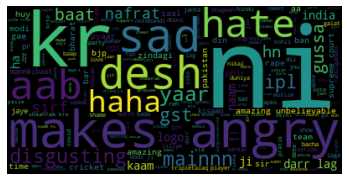

In [11]:
common_words=''
for i in df.tweets:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Tokenizing Tweets

In [12]:
nltk.download('punkt')

from nltk import word_tokenize
tokens = (word_tokenize(i) for i in df.tweets)

df['tokens'] = df['tweets'].apply(nltk.word_tokenize)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,tweets,labels,tokens
0,khel khatam england cricket youtube channel ja...,0,"[khel, khatam, england, cricket, youtube, chan..."
1,purana manjan bech,5,"[purana, manjan, bech]"
2,disappointed ni,0,"[disappointed, ni]"
3,tiktok banva batting ni cricket,3,"[tiktok, banva, batting, ni, cricket]"
4,cricket tweets lanka lag jaati makes angry,3,"[cricket, tweets, lanka, lag, jaati, makes, an..."


In [13]:
df1 = pd.get_dummies(df['labels'])
df1

,0,1,2,3,4,5,6
0,1,0,0,0,0,0,0
1,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...
9160,0,0,0,1,0,0,0
9161,0,0,0,1,0,0,0
9162,0,0,0,1,0,0,0
9163,0,0,1,0,0,0,0


In [14]:
df2 = df.copy()
df2

,tweets,labels,tokens
0,khel khatam england cricket youtube channel ja...,0,"[khel, khatam, england, cricket, youtube, chan..."
1,purana manjan bech,5,"[purana, manjan, bech]"
2,disappointed ni,0,"[disappointed, ni]"
3,tiktok banva batting ni cricket,3,"[tiktok, banva, batting, ni, cricket]"
4,cricket tweets lanka lag jaati makes angry,3,"[cricket, tweets, lanka, lag, jaati, makes, an..."
...,...,...,...
9160,gujarati fraud hotey pnbscam,3,"[gujarati, fraud, hotey, pnbscam]"
9161,saala idhar lakh car loan bank chooos leti cr...,3,"[saala, idhar, lakh, car, loan, bank, chooos, ..."
9162,mitron nirav modi ji relation india rich indus...,3,"[mitron, nirav, modi, ji, relation, india, ric..."
9163,yahn month education loan emi pay ni call aa p...,2,"[yahn, month, education, loan, emi, pay, ni, c..."


In [15]:
df = pd.concat([df2,df1], axis=1)
df

,tweets,labels,tokens,0,1,2,3,4,5,6
0,khel khatam england cricket youtube channel ja...,0,"[khel, khatam, england, cricket, youtube, chan...",1,0,0,0,0,0,0
1,purana manjan bech,5,"[purana, manjan, bech]",0,0,0,0,0,1,0
2,disappointed ni,0,"[disappointed, ni]",1,0,0,0,0,0,0
3,tiktok banva batting ni cricket,3,"[tiktok, banva, batting, ni, cricket]",0,0,0,1,0,0,0
4,cricket tweets lanka lag jaati makes angry,3,"[cricket, tweets, lanka, lag, jaati, makes, an...",0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
9160,gujarati fraud hotey pnbscam,3,"[gujarati, fraud, hotey, pnbscam]",0,0,0,1,0,0,0
9161,saala idhar lakh car loan bank chooos leti cr...,3,"[saala, idhar, lakh, car, loan, bank, chooos, ...",0,0,0,1,0,0,0
9162,mitron nirav modi ji relation india rich indus...,3,"[mitron, nirav, modi, ji, relation, india, ric...",0,0,0,1,0,0,0
9163,yahn month education loan emi pay ni call aa p...,2,"[yahn, month, education, loan, emi, pay, ni, c...",0,0,1,0,0,0,0


# Splitting data into train and test:

18


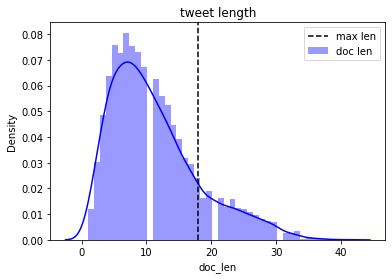

In [16]:
data_train, data_test = train_test_split(df, test_size=0.2, random_state=3)
X_train = data_train['tweets'].values
X_test = data_test['tweets'].values
y_train = data_train['labels'].values
y_test = data_test['labels'].values

data_train['doc_len'] = data_train['tweets'].astype(str).apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(data_train['doc_len'].mean() + data_train['doc_len'].std()).astype(int)
print(max_seq_len)
sns.distplot(data_train['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('tweet length'); 
plt.legend()
plt.show()

In [17]:
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

81292 words total, with a vocabulary size of 18519
Max sentence length is 41


In [18]:
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

20342 words total, with a vocabulary size of 7302
Max sentence length is 37


In [19]:
word2vec_path = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [20]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [21]:
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

## Pad sequences - Padding input sequence to make shape and size each tweets equal

In [22]:
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["tweets"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["tweets"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 18520 unique tokens.


In [23]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

### Calculating embedding dimension

In [24]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(18521, 300)


In [25]:
test_sequences = tokenizer.texts_to_sequences(data_test["tweets"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Define CNN

In [26]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3,4,5,6]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=250, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)


    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    preds = Dense(labels_index, activation='softmax')(x) # The output layer with 7 output values, one for each class. Activation function is 'softmax' for multi-class classification problem

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',       # This multi-class classification problem, 'categorical_crossentropy' is used as the loss function
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [27]:
label_names = [0,1,2,3,4,5,6]

In [28]:
y_train = data_train[label_names].values

x_train = train_cnn_data
y_tr = y_train

In [29]:
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, len(list(label_names)))

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 300)      5556300     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 49, 250)      150250      ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 48, 250)      225250      ['embedding[0][0]']              
                                                                                              

### Plotting CNN Model

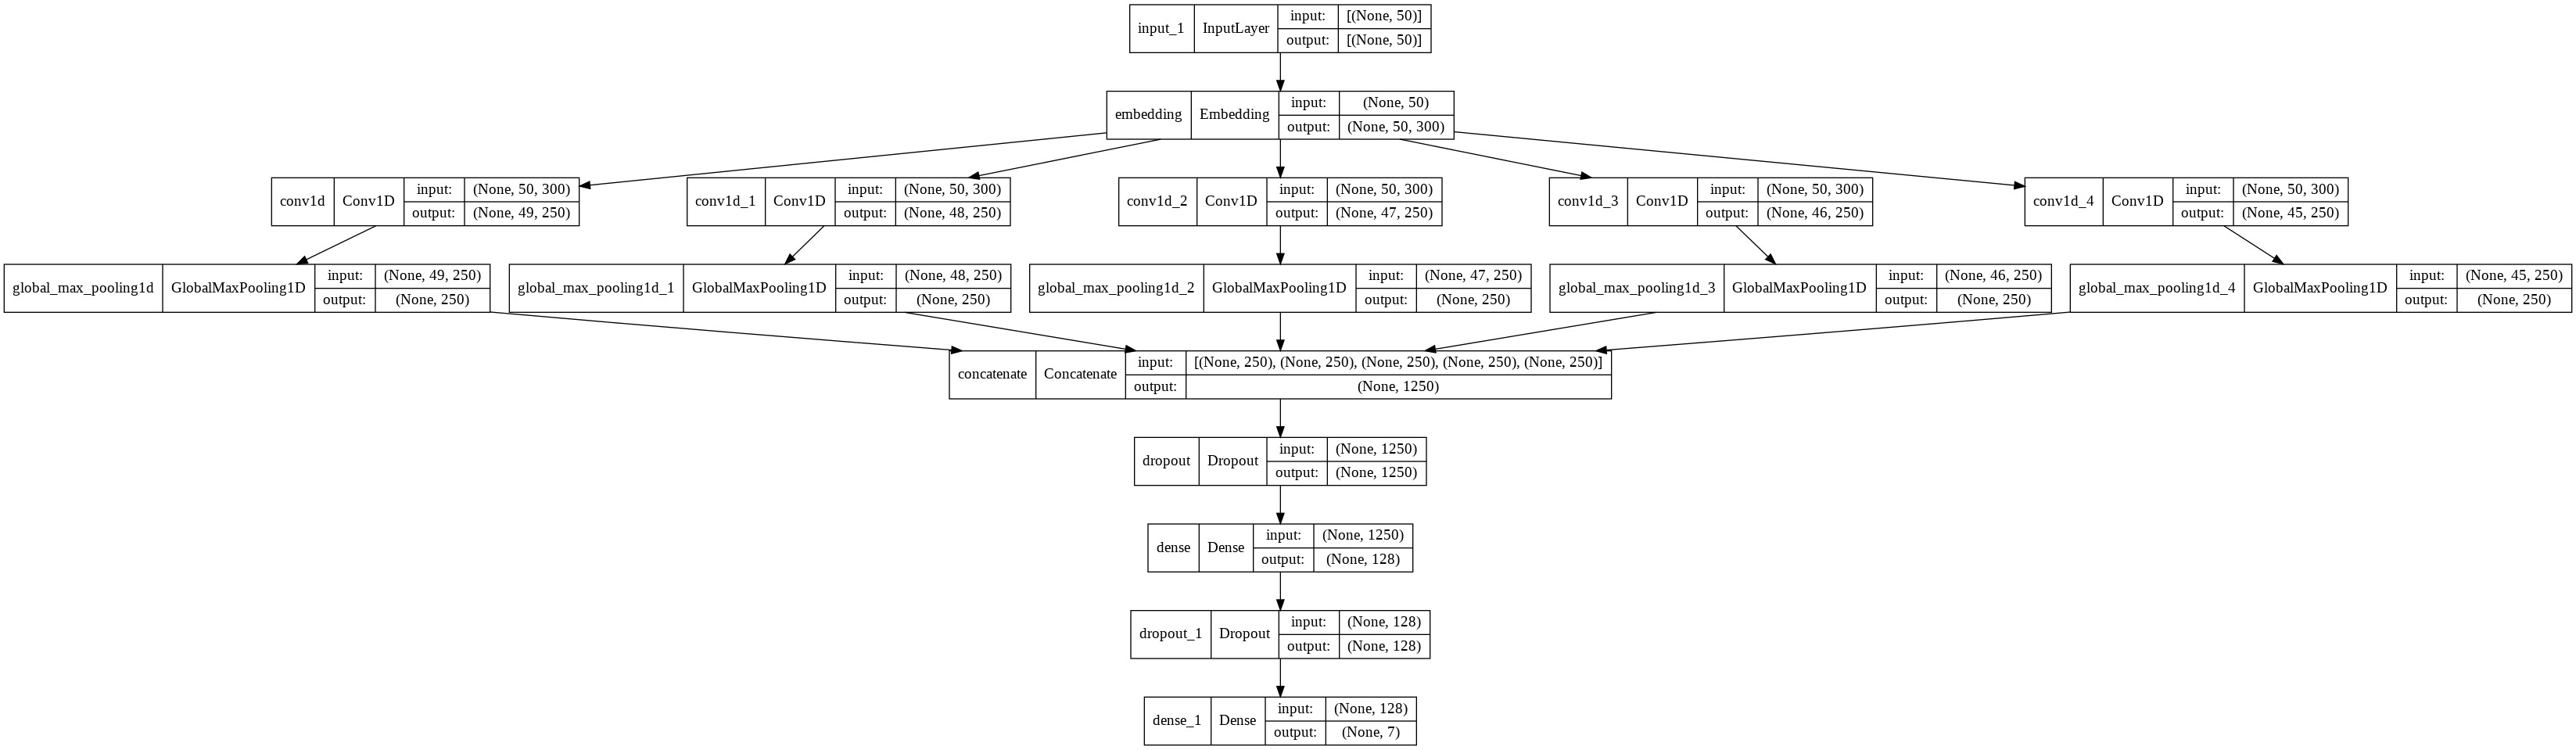

In [31]:
plot_model(model, show_shapes=True, show_layer_names=True)

# Training Model:

In [32]:
num_epochs = 5
batch_size = 64

In [33]:
hist = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Epoch 1/5
104/104 [==============================] - 9s 53ms/step - loss: 1.8404 - accuracy: 0.2461 - val_loss: 1.5666 - val_accuracy: 0.3624
Epoch 2/5
104/104 [==============================] - 3s 31ms/step - loss: 1.5066 - accuracy: 0.3850 - val_loss: 1.3429 - val_accuracy: 0.5163
Epoch 3/5
104/104 [==============================] - 3s 30ms/step - loss: 1.2237 - accuracy: 0.5305 - val_loss: 0.9653 - val_accuracy: 0.6703
Epoch 4/5
104/104 [==============================] - 3s 31ms/step - loss: 0.9816 - accuracy: 0.6488 - val_loss: 0.8941 - val_accuracy: 0.6744
Epoch 5/5
104/104 [==============================] - 3s 31ms/step - loss: 0.8616 - accuracy: 0.6864 - val_loss: 0.8809 - val_accuracy: 0.6894


In [34]:
predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)

2/2 [==============================] - 1s 497ms/step


In [35]:
labels = [0,1,2,3,4,5,6]

In [36]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

### Calculating Accuracy for Test set

In [37]:
sum(data_test.labels==prediction_labels)/len(prediction_labels)

0.6824877250409165

### Plotting Training and Validation Loss

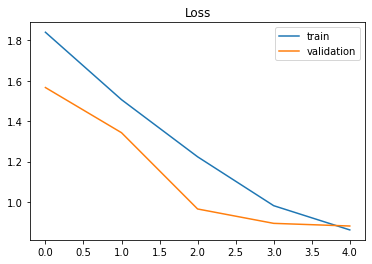

In [38]:
plt.title('Loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend()
plt.show();

### Plotting Training and Validation Accuracy

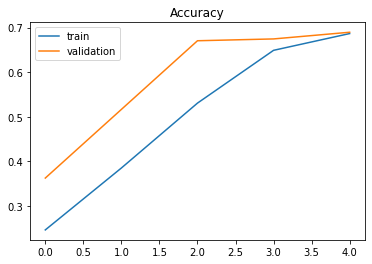

In [39]:
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.legend()
plt.show();